<a href="https://colab.research.google.com/github/wendy-ha/cityscapes_unet_deeplearning/blob/main/CityScapes_Deeplearning_UNet_04102022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

##Project Overview

* Project's title: **SEMANTIC SEGMENTATION OF URBAN SCENE IMAGES USING U-NET NETWORK ARCHITECTURES**
* Authors: Wendy Ha
* Creation Date: 25/10/2022

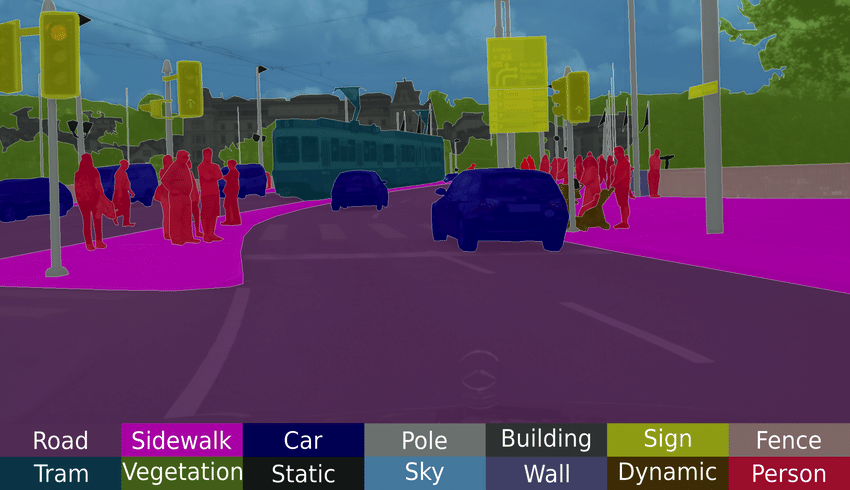

**1. Background**

In Autonomous Driving Vehicles, the vehicle receives pixel-wise sensor data from RGB cameras, point-wise depth information from the cameras, and sensors data as input. The computer present inside the Autonomous Driving vehicle processes the input data and provides the desired output, such as steering angle, torque, and brake.

To make an accurate decision by the vehicle, the computer inside the vehicle should be completely aware of its surroundings and understand each pixel in the driving scene. Semantic Segmentation is the task of assigning a class label (such as Car, Road, Pedestrian, or Sky) to each pixel in the given image.

> A better performing Semantic Segmentation algorithm will contribute to the advancement of the Autonomous Driving field.

**2. Project objective & scope**

After studying certain deep learning frameworks, I aim to utilise these knowledge in this demonstration to achieve 02 main goals:

- Experience the whole Deep Learning Development Cycle with CityScapes dataset. This process begins with data collecting, data partitioning, data preprocessing, data exploration, model building, and concludes with model performance evaluation
- Successfully develop 01 Segmentation models, U-Net on the CityScapes dataset. I hope that the insights gained during the creation of these two models will assist autonomous driving companies such as Tesla, Waymo, Baidu Apollo in improving the precision of identifying and detecting targets in urban environments.

##Importing Libraries

In [ ]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

##GPUs

GPUs have a higher number of logical cores through which they can attain a higher level of parallelization and can provide better and fast results to computation as compared to CPUs. As in deep learning tasks, the number of parameters to train can go up to billions. As we know in a neural network to adjust the weight matrix operations such as matrix multiplication are performed which is a costly operation to be done on a CPU. To perform these faster multiple operations need to be done simultaneously. GPU has better parallelization support and also the memory required for deep learning models is also huge and can be suitable for a GPU.

I may have a GPU but my model might not be using it. In this case, the training will be done on the CPU by default. Hence it is necessary to check whether Tensorflow is running the GPU it has been provided.

### Releasing GPU memory
This will clear the current session (Graph) and so the stale model should be removed from GPU.

In [ ]:
from keras import backend as K
K.clear_session()

###Find GPU device

In [ ]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


###Information of the GPU that the Tensorflow is running on

In [ ]:
!nvidia-smi

Mon Oct  3 12:14:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#PART 1: Exploratory Data Analysis (EDA)

##Mount google drive into colab root content/

In [ ]:
#Mount google drive into colab root content/
from google.colab import drive
drive.mount('/content/gDrive')

Mounted at /content/gDrive


In [ ]:
#Note: This dataset has been converted 35 classes into 20 classes by replacing 
#dst = f.replace( "_polygons.json" , "_labelTrainIds.png" ) with dst = f.replace( "_polygons.json" , "_trainIds.png" )
#in cityscapesscripts/preparation/createTrainIdLabelImgs.py
#Reference: https://github.com/junfu1115/DANet/issues/12

In [ ]:
#Use content >> cityscapes >> meta >> label_imgs folder for training
#Reference: https://github.com/mcordts/cityscapesScripts/issues/8

##Extract dataset

In [ ]:
!echo "r"|unzip '/content/gDrive/MyDrive/cityscapes.zip' -d '/content/gDrive/MyDrive/cityscapes_converted_mask/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/tubingen/tubingen_000047_000019_gtFine_labelTrainIds.png  
  inflating: /content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/tubingen/tubingen_000101_000019_gtFine_labelIds.png  
  inflating: /content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/tubingen/tubingen_000060_000019_gtFine_labelTrainIds.png  
  inflating: /content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/tubingen/tubingen_000142_000019_gtFine_labelTrainIds.png  
  inflating: /content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/tubingen/tubingen_000000_000019_gtFine_polygons.json  
  inflating: /content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/tubingen/tubingen_000128_000019_gtFine_labelTrainIds.png  
  inflating: /content/gDrive/MyDri

In [ ]:
#check head/tail of images folder
! ls '/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/leftImg8bit/train/aachen' | head

aachen_000000_000019_leftImg8bit.png
aachen_000001_000019_leftImg8bit.png
aachen_000002_000019_leftImg8bit.png
aachen_000003_000019_leftImg8bit.png
aachen_000004_000019_leftImg8bit.png
aachen_000005_000019_leftImg8bit.png
aachen_000006_000019_leftImg8bit.png
aachen_000007_000019_leftImg8bit.png
aachen_000008_000019_leftImg8bit.png
aachen_000009_000019_leftImg8bit.png


In [ ]:
#check head/tail of label folder
! ls '/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/aachen' | head

aachen_000000_000019_gtFine_color.png
aachen_000000_000019_gtFine_instanceIds.png
aachen_000000_000019_gtFine_labelIds.png
aachen_000000_000019_gtFine_labelTrainIds.png
aachen_000000_000019_gtFine_polygons.json
aachen_000001_000019_gtFine_color.png
aachen_000001_000019_gtFine_instanceIds.png
aachen_000001_000019_gtFine_labelIds.png
aachen_000001_000019_gtFine_labelTrainIds.png
aachen_000001_000019_gtFine_polygons.json


##Create path for Features and Labels of dataset
- leftImg8bit: feature folder (X_train, X_val, X_test)
- gtFine: label folder (Y_train, Y_val, Y_test)

In [ ]:
train_image_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/leftImg8bit/train/*/*.png"
train_label_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/*/*_gtFine_labelIds.png"
train_color_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/*/*_gtFine_color.png"
#-----
val_image_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/leftImg8bit/val/*/*.png"
val_label_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/val/*/*_gtFine_labelIds.png"
val_color_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/val/*/*_gtFine_color.png"
#-----
test_image_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/leftImg8bit/test/*/*.png"
test_label_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/test/*/*_gtFine_labelIds.png"
test_color_path = "/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/test/*/*_gtFine_color.png"

In [ ]:
#Sort file in folder into ascending order
train_images = sorted(glob.glob(train_image_path))
train_labels = sorted(glob.glob(train_label_path))
train_colors = sorted(glob.glob(train_color_path))
#-----

val_images = sorted(glob.glob(val_image_path))
val_labels = sorted(glob.glob(val_label_path))
val_colors = sorted(glob.glob(val_color_path))

#-----
test_images = sorted(glob.glob(test_image_path))
test_labels = sorted(glob.glob(test_label_path))
test_colors = sorted(glob.glob(test_color_path))

In [ ]:
#random check index in train/val/test sets to see whether they are matched with each other or not
train_images[1000], train_labels[1000], val_images[400], val_labels[400], test_images[500], test_labels[500]

('/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000175_000019_leftImg8bit.png',
 '/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/train/dusseldorf/dusseldorf_000175_000019_gtFine_labelIds.png',
 '/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/leftImg8bit/val/munster/munster_000074_000019_leftImg8bit.png',
 '/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/val/munster/munster_000074_000019_gtFine_labelIds.png',
 '/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/leftImg8bit/test/berlin/berlin_000500_000019_leftImg8bit.png',
 '/content/gDrive/MyDrive/cityscapes_converted_mask/content/cityscapes/gtFine/test/berlin/berlin_000500_000019_gtFine_labelIds.png')

##Verify total images and dimension

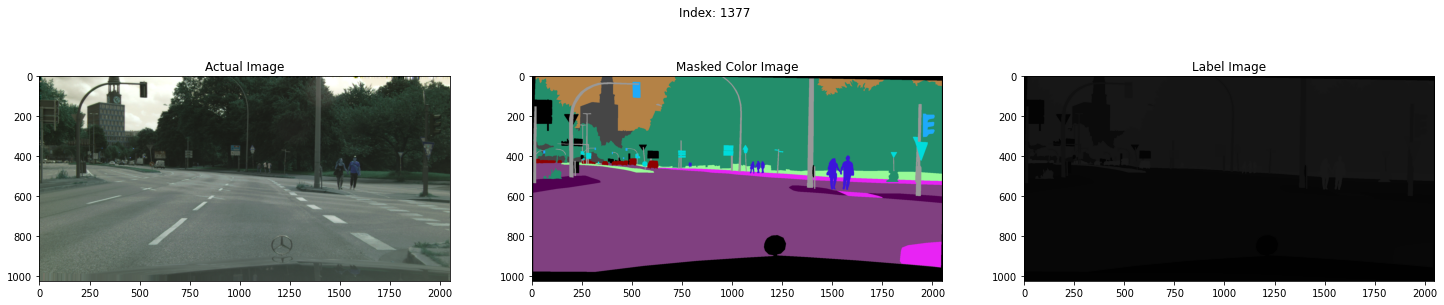

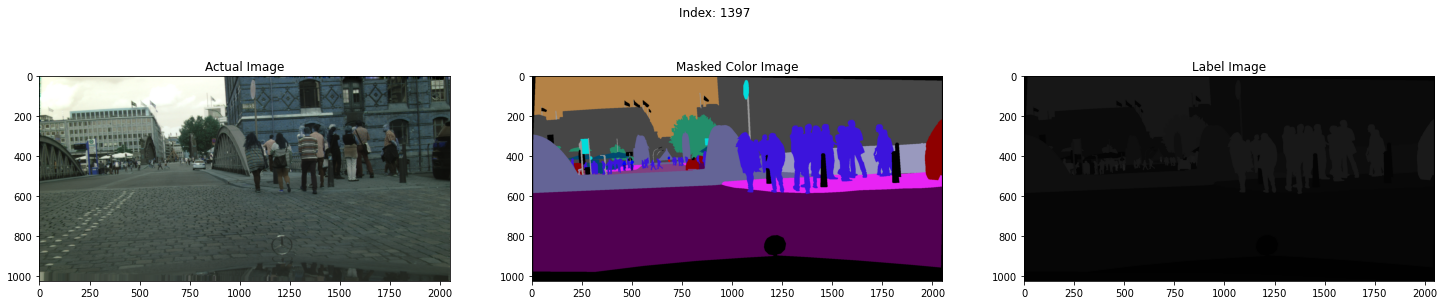

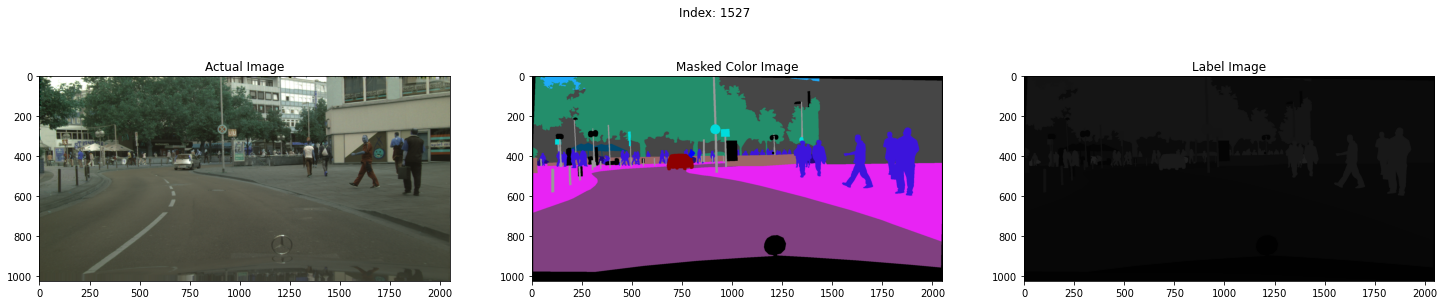

-- -- -- -- -- -- -- -- -- -- 
total training images: 2975
total training masked: 2975
total validation images: 500
total validation masked: 500
total test images: 1525
total test masked: 1525
-- -- -- -- -- -- -- -- -- -- 
384
<class 'int'>
train images shape:  (1024, 2048, 3)
train masks shape:  (1024, 2048, 3)
val images shape:  (1024, 2048, 3)
val masks shape:  (1024, 2048, 3)
test images shape:  (1024, 2048, 3)
test masks shape:  (1024, 2048, 3)


In [ ]:
for i in range(3):
  s_i = np.random.randint(0, len(train_labels))
  # print(s_i)

  s1 = cv2.imread(train_images[s_i]) # train images
  s2 = cv2.imread(train_colors[s_i])  # train colors
  s2_1 = cv2.imread(train_labels[s_i])  # train masks
 

  fig, axes = plt.subplots(1, 3, figsize=(25, 5))
  axes[0].imshow(s1)
  axes[0].set_title('Actual Image')
  axes[1].imshow(s2)
  axes[1].set_title('Masked Color Image')
  axes[2].imshow(s2_1)
  axes[2].set_title('Label Image')
  fig.suptitle("Index: %i" %s_i)
  plt.show()

# Display the number of training & validation images
print('-- '*10)
print('total training images:', len(train_images))
print('total training masked:', len(train_labels))
print('total validation images:', len(val_images))
print('total validation masked:', len(val_labels))
print('total test images:', len(test_images))
print('total test masked:', len(test_labels))
print('-- '*10)

# randomly spot check image size
import cv2
s_i = np.random.randint(0, 500)
print(s_i)
print(type(s_i))

s1 = cv2.imread(train_images[s_i])
s2 = cv2.imread(train_labels[s_i])
s3 = cv2.imread(val_images[s_i])
s4 = cv2.imread(val_labels[s_i])
s5 = cv2.imread(test_images[s_i])
s6 = cv2.imread(test_labels[s_i])

print("train images shape: ", s1.shape)
print("train masks shape: ", s2.shape)
print("val images shape: ", s3.shape)
print("val masks shape: ", s4.shape)
print("test images shape: ", s5.shape)
print("test masks shape: ", s6.shape)

##cityscapesscripts respository

###Importing cityscapesscripts respository from github

In [ ]:
#Directory: https://github.com/erancihan/cityscapesScripts

In [ ]:
!python -m pip install cityscapesscripts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 472 kB 5.2 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 46 kB 2.5 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=87b8dac429e6342a33a6f6dcbc4fef571abca2cc4fae84a97faee55e5a43bc5b
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


###Load label.py

In [ ]:
from cityscapesscripts.helpers import labels as helper_labels
labels = helper_labels.labels
# Print all the labels
print("List of cityscapes labels:")
print("")
print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12} | {:>1}"
      .format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color' ))
print("    " + ('-' * 110))
for label in labels:
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12} | {}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval, label.color))
print("")

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval | color
    --------------------------------------------------------------------------------------------------------------
                unlabeled |   0 |     255 |           void |          0 |            0 |            1 | (0, 0, 0)
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1 | (0, 0, 0)
     rectification border |   2 |     255 |           void |          0 |            0 |            1 | (0, 0, 0)
               out of roi |   3 |     255 |           void |          0 |            0 |            1 | (0, 0, 0)
                   static |   4 |     255 |           void |          0 |            0 |            1 | (0, 0, 0)
                  dynamic |   5 |     255 |           void |          0 |            0 |            1 | (111, 74, 0)
                   ground |   6 |     255 |           void |

###List of 20 classes we should keep

In [ ]:
#For trainIds 255, keep for 'unlabelled' class, ignore for the others 255
#Reference: https://github.com/erancihan/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

ignore_index=255
valid_trainIds_classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,-1, ignore_index] #trainIds
class_names = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle', 'unlabelled']
num_classes = 20
#why i choose 20 classes
#https://stackoverflow.com/a/64242989

class_map = dict(zip(valid_trainIds_classes, range(len(valid_trainIds_classes))))
n_classes=len(valid_trainIds_classes)
class_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 -1: 19,
 255: 20}

###Verify whether we have successfully converted 20 classes labels

Map color to closest member in 20 classes


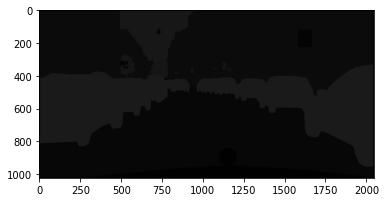

Classes list:  [ 1  3  4  7  8 11 17 20 21 23 26]
No. of unique classes:  11



In [ ]:
# Double check list of unique classes in a random image
# ref: https://stackoverflow.com/questions/57496971/map-colors-in-image-to-closest-member-of-a-list-of-colors-in-python

for i in range(1):
  s_i = np.random.randint(0, len(train_labels))
  img = cv2.imread(train_labels[s_i])

  # ref: https://stackoverflow.com/questions/24780697/numpy-unique-list-of-colors-in-the-image

  print("Map color to closest member in 20 classes")
  plt.imshow(img, cmap='magma')
  plt.show()
  print("Classes list: ", np.unique(img.reshape(-1), axis=0))
  print("No. of unique classes: ", len(np.unique(img.reshape(-1), axis=0)))
  print()




In [ ]:
#NOTE: Because I still use 35 classes dataset so the classes list here (having class 23 and 26) is not correct. 
#It will be corrected when I change to 20 classess dataset

#PART 2: Data Preprocessing

##Recreate dataset for training, validating and testing

In [ ]:
#train dataset includes: X_train(train images) + Y_train(train labels)
dataset_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

#validation dataset includes: X_val(val images) + Y_val(val labels)
dataset_val = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

#test dataset includes: X_test(test images) + Y_test(test labels)
dataset_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

##Initializing Hyperparameters

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
BUFFER_SIZE = 300
EPOCHS = 30
auto = tf.data.experimental.AUTOTUNE
num_classes = 34 # num_classes = 20 for real converted dataset

##Base models creation

###Read images in path

In [ ]:
def read_png(path, channels=3): 
    # path:  image or label path, if image path, channels=3.  if label path, channels=1
    # because in this training, we read label is  gtFine_labelIds.png(channels=1) ,  not _gtFine_color.png
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=channels)
    return img

###Resize images

In [ ]:
def crop_img(img, label):
    concat_img = tf.concat([img, label], axis=-1)
    concat_img = tf.image.resize(concat_img, (280, 280), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [IMG_SIZE, IMG_SIZE, 4])
    # tf.image.random_crop， crop a tensor to a given size randomly, here is [256, 256, 4]
    # images and labels are cropped at the same time to maintain consistency,  so need to concat([img, label]) 
    return crop_img[:, :, 0:3], crop_img[:, :, 3:]

###Normalize pixel values from range [0-255] to range [0-1] in images

In [ ]:
def normal(img, label):
    #pixel values ranging from 0 to 255 --> normalize to 0 to 1
    #Reference: https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html
    img = tf.cast(img, tf.float32)/255.0 
    label = tf.cast(label, tf.int32)
    return img, label

##Appling base models to convert train/val/test dataset

In [ ]:
def load_image_train(img_path, label_path):
    img = read_png(img_path)
    label = read_png(label_path, channels=1)
    img, label = crop_img(img, label)
    #data argument, Outputs the contents of image flipped along the width dimension.
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        label = tf.image.flip_left_right(label)           
    img, label = normal(img, label)
    return img, label

def load_image_val(img_path, label_path):
    
    img = read_png(img_path)
    label = read_png(label_path, channels=1)
    
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    label = tf.image.resize(label, (IMG_SIZE, IMG_SIZE))
    
    img, label = normal(img, label)
    return img, label

def load_image_test(img_path, label_path):
    
    img = read_png(img_path)
    label = read_png(label_path, channels=1)
    
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    label = tf.image.resize(label, (IMG_SIZE, IMG_SIZE))
    
    img, label = normal(img, label)
    return img, label

##Produce official train/test/set dataset for training model

In [ ]:
#Input dataset into load_image_train/val/test functions to create new dataset for training model
dataset_train = dataset_train.map(load_image_train, num_parallel_calls=auto)
dataset_val =dataset_val.map(load_image_val, num_parallel_calls=auto)
dataset_test =dataset_test.map(load_image_test, num_parallel_calls=auto)

dataset_train = dataset_train.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(auto)
dataset_val = dataset_val.cache().batch(BATCH_SIZE)
dataset_test = dataset_test.cache().batch(BATCH_SIZE)

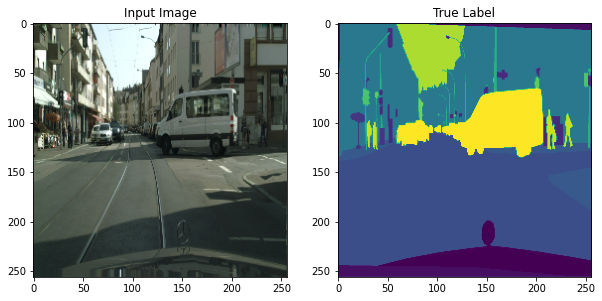

In [ ]:
#Display randomly an image and label after resize and normalise
#to see whether they have successfully been converted and normalised or not
for image, label in dataset_val.take(1):
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.title('Input Image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[5]))
    plt.subplot(122)
    plt.title('True Label')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(label[5])) 

#PART 3: Deep Learning Model

In [ ]:
#put list of images into numpy array to can count number of value input (= len of array)
index = np.random.permutation(len(train_images))
train_images = np.array(train_images)[index]
train_labels = np.array(train_labels)[index]

In [ ]:
#initialize train_step_per_epoch to monitor model when it's running 
train_count = len(train_images)
val_count = len(val_images)
test_count = len(test_images)
train_step_per_epoch = train_count // BATCH_SIZE
val_step_per_epoch = val_count // BATCH_SIZE
test_step_per_epoch = test_count // BATCH_SIZE

##Design UNet Model

In [ ]:
def get_unet_model():
    
    inputs = tf.keras.layers.Input(shape = [IMG_SIZE, IMG_SIZE, 3])
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
 
    #   x shape  (None, 256, 256, 64)
    x1 = tf.keras.layers.MaxPooling2D(padding='same')(x)
    # (None, 128, 128, 64)
    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1= tf.keras.layers.BatchNormalization()(x1)
    #  shape  (None, 128, 128, 128)
        
    x2 = tf.keras.layers.MaxPooling2D(padding='same')(x1)
    # shape N(one, 64, 64, 128)
    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2= tf.keras.layers.BatchNormalization()(x2)
    #  shape  (None, 64, 64, 256)  
    
    x3 = tf.keras.layers.MaxPooling2D(padding='same')(x2)
    #     shape  (None, 32, 32, 256) 
    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3= tf.keras.layers.BatchNormalization()(x3)
    #  shape  (None, 32, 32, 512)  
    
    x4 = tf.keras.layers.MaxPooling2D(padding='same')(x3)
    #     shape  (None, 16, 16, 512) 
    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4= tf.keras.layers.BatchNormalization()(x4)
    #  shape  (None, 16, 16, 1024)    
    
    x5 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same',
                                        activation='relu')(x4)
    x5 = tf.keras.layers.BatchNormalization()(x5)
#     print("x3, x5 shape:", x3.shape, x5.shape)
    x6 = tf.concat([x3, x5], axis=-1)
    #  shape  (None, 32, 32, 1024)
    
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)    
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6= tf.keras.layers.BatchNormalization()(x6)
    #    (None, 32, 32, 512)
    
    x7= tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same',
                                        activation='relu')(x6)
    x7 = tf.keras.layers.BatchNormalization()(x7)
#     print("x2, x7 shape:", x2.shape, x7.shape)
    x8 = tf.concat([x2, x7], axis=-1)
    #   (None, 64, 64, 512)
    
    
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)    
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8= tf.keras.layers.BatchNormalization()(x8)
    #    (None, 64, 64, 256)
    
    x9= tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same',
                                        activation='relu')(x8)
    x9 = tf.keras.layers.BatchNormalization()(x9)
    #   (None, 128, 128, 128)
#     print("x1, x9 shape:", x1.shape, x9.shape)
    x10 = tf.concat([x1, x9], axis=-1)
    #   (None, 128, 128, 256)
    
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)    
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    #    (None, 128, 128, 128)  
    
    
    x11= tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same',
                                        activation='relu')(x10)
    x11 = tf.keras.layers.BatchNormalization()(x11)
#     print("x, x11 shape:", x.shape, x11.shape)
    x11 = tf.concat([x, x11], axis=-1)
    #   (None, 256, 256, 128) 
    
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x11)
    x12 = tf.keras.layers.BatchNormalization()(x12)    
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    #    (None, 256, 256, 64) 
    
    output = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(x12)
  
    
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = get_unet_model()

###Plot model to dot format for saving

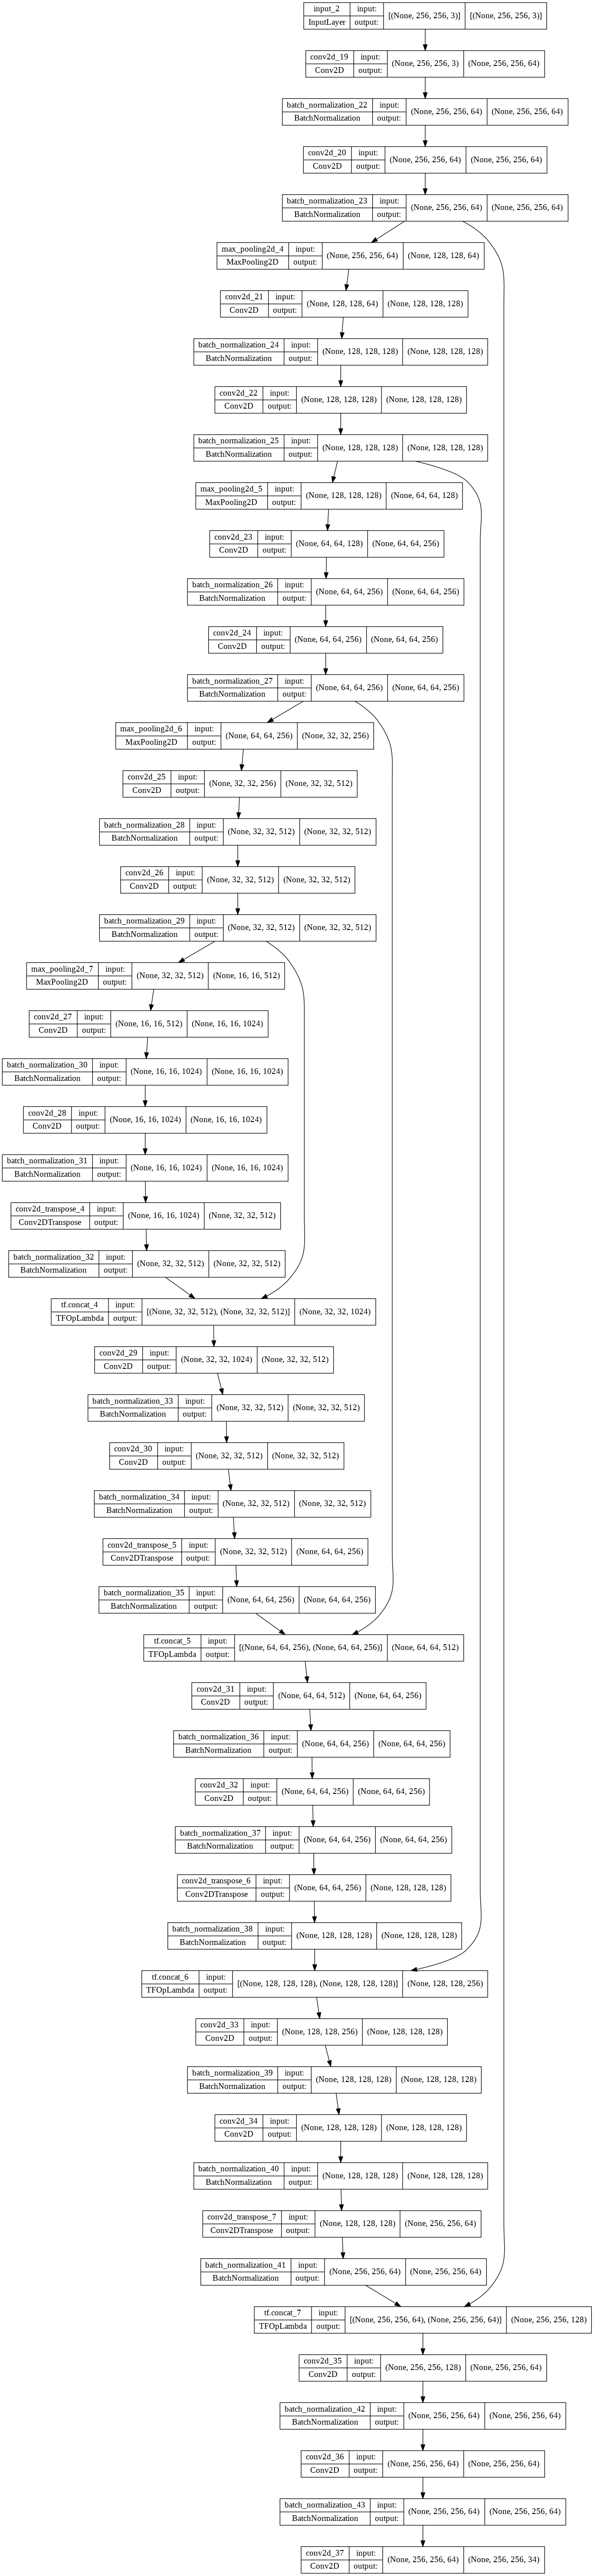

In [ ]:
#Converts a Keras model to dot format and save to a file (if needed)
tf.keras.utils.plot_model(model, show_shapes = True, to_file='TDP_UNet_model1.png')

##Utility Metrics and Callbacks classes

###MeanIoU (key metrics to evaluate model's performance)

In [ ]:
#tf.keras.metrics.MeanIoU(34) - the parameter is the number of categories
#But since this function uses the category representation method of one-hot encoding, and the number of categories 
#in this example is sparsely represented, not one-hot encoding, it is necessary to make some changes to the function

class MeanIoU(tf.keras.metrics.MeanIoU):
     def update_state(self, y_true, y_pred, sample_weight=None):
         y_pred = tf.argmax(y_pred, axis=-1)
         return super().update_state(y_true, y_pred, sample_weight)

##UNet Model Training

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=num_classes, name = "mean_iou")])

In [ ]:
import time
start = time.time()
history = model.fit(dataset_train, 
                    epochs=EPOCHS, 
                    steps_per_epoch=train_step_per_epoch,
                    validation_steps=val_step_per_epoch,
                    validation_data=dataset_val
                    )

end = time.time()
print(str(int(end - start)))

Epoch 1/30
92/92 [==============================] - 98s 1s/step - loss: 0.7652 - accuracy: 0.7903 - mean_iou: 0.1551 - val_loss: 13.1655 - val_accuracy: 0.3393 - val_mean_iou: 0.0141
Epoch 2/30
92/92 [==============================] - 94s 1s/step - loss: 0.6735 - accuracy: 0.8143 - mean_iou: 0.1765 - val_loss: 9.5976 - val_accuracy: 0.3629 - val_mean_iou: 0.0202
Epoch 3/30
92/92 [==============================] - 94s 1s/step - loss: 0.6330 - accuracy: 0.8249 - mean_iou: 0.1921 - val_loss: 2.6881 - val_accuracy: 0.4705 - val_mean_iou: 0.0610
Epoch 4/30
92/92 [==============================] - 94s 1s/step - loss: 0.5952 - accuracy: 0.8338 - mean_iou: 0.2042 - val_loss: 1.8658 - val_accuracy: 0.5870 - val_mean_iou: 0.0750
Epoch 5/30
92/92 [==============================] - 94s 1s/step - loss: 0.5745 - accuracy: 0.8386 - mean_iou: 0.2134 - val_loss: 1.0327 - val_accuracy: 0.7235 - val_mean_iou: 0.1542
Epoch 6/30
92/92 [==============================] - 96s 1s/step - loss: 0.5590 - accuracy

##Training Result

###Prediction on train set

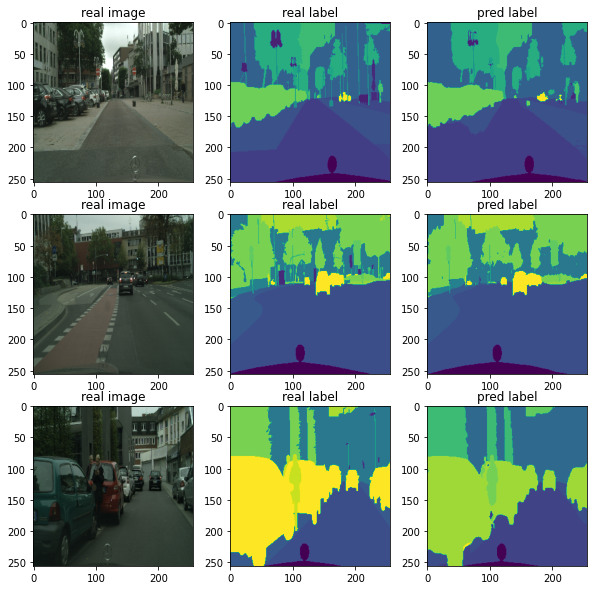

In [ ]:
num = 3
for image, mask in dataset_train.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.title('real image')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.title('real label')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.title('pred label')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

###Compare Loss, Accuracy, MeanIoU between train and predicted images

In [ ]:
def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

###Visualize performance metrics comparison

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

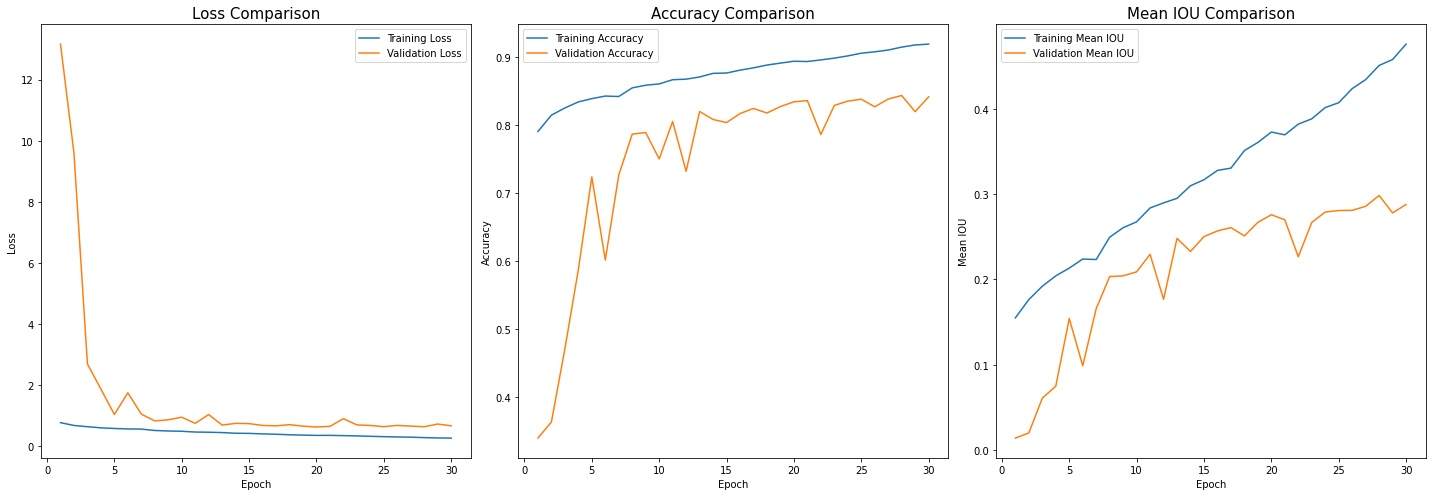

In [ ]:
import seaborn as sns
plot_history(history)

#PART 4: Model prediction on validation and test dataset

##Test on validation set

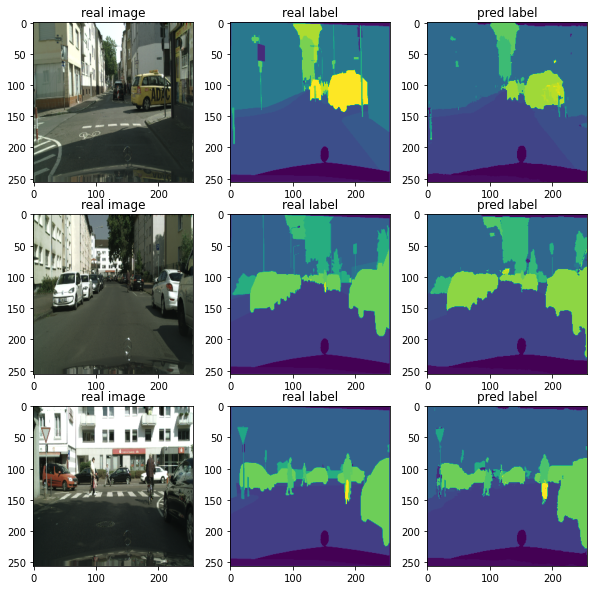

In [ ]:
num = 3
for image, mask in dataset_val.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.title('real image')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.title('real label')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.title('pred label')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

##Test on test dataset

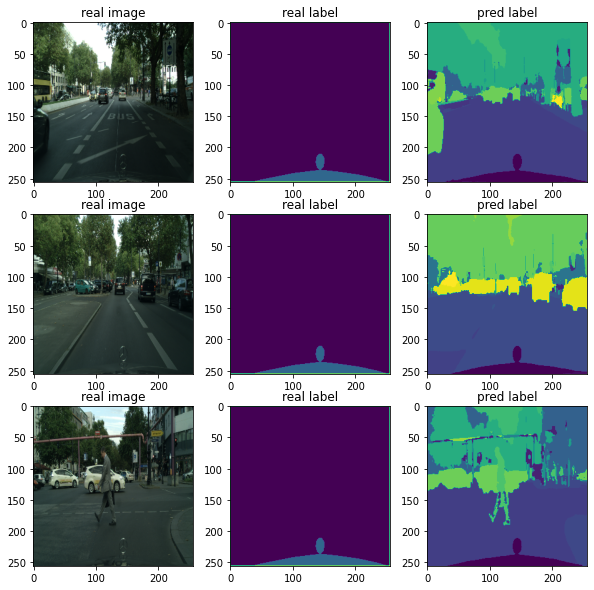

In [ ]:
for image, mask in dataset_test.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.title('real image')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.title('real label')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.title('pred label')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

##Conclusion